### TODO
- For Schleife über die Querschnitts dicken funktioniert nicht -> Ergibt einen Dataframe aber müsst bei aktueller Struktur pro dicke einen DF erstellen und die jeweils in Excel schreiben. So muss alles hier für jede QS Stärke seperat gestartet werden. Zudem muss beim ersten durchlauf eine leere Excel Datei mit dem entsprechenden Namen erstellt werden.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join as os_join
import pandas as pd

from source.model import BeamModel
import source.postprocess as postprocess
from source.utilities import utilities as utils
from source.Querschnitte import nEck, KreisRing
import source.utilities.global_definitions as GD
from inputs import holz, spannglieder


2D Euler-Bernoulli Balken:

x-Achse: Längsrichtung
y-Achse: Querrichtung
gamma: Verdrehung
Biegung um z-Achse
(keine Torsion)

![Balken](Beschreibungen/Balken_cosy.png)

# Definieren der (Grund) Geometrischen sowie der Material Parameter

Abschnittsweise veränderliche Querschnittswerte werden nach erstellen der Querschnitte nEck und KreisRing ergänzt: 'defined on intervals'

Derzeit werden die anzahl der FE Elemente an die anzahl der Intervalle/Sektionen angepasst. 


In [2]:
parameters = {
               'dimension': '2D',
                'n_elements': 20, #
                'lx_total_beam': 130,
                'material_density': 904,# 500,#42, #für dynamische Berechnung äquivalenter Wert
                'total_mass_tower': 668390,# aus RFEM
                'nacelle_mass': 267910,# IEA37: Gondel Masse in kg # aus optimierung 287920.5
                'vorspannkraft':12*2.5E+06, # N
                'imperfektion':0.008, # m/m Schiefstellung infolge Montage (5mm/m) + Baugrundsetzung (3 mm/m)
                'E_Modul': 12000E+06,# N/m²
                'nu': 0.1, # querdehnung
                'damping_coeff': 0.025,
                'nodes_per_elem': 2,
                'Iz': 51.0,# Not used if defined on intervals
                'dofs_of_bc':[0,1,2], # Einspannung
                'type_of_bc':'clamped',#'clamped',# or 'spring'
                'spring_stiffness':[1E+13,2E+13], # Federsteifigkeit am Boden in u und gamma richtung Bögl 40 GNm/rad
                'dynamic_load_file': os_join(*["inputs","forces","dynamic_force_11_nodes.npy"]),
                'eigen_freqs_target':[0.133,0.79,3.0], 
                'defined_on_intervals':[] # kann gefüllt werden mit einer pickle datei 
            }
holzgüte = 'C30'
n_nodes = parameters['n_elements']+1

werkstoff_parameter = holz.charakteristische_werte[holzgüte]
parameters['material_density'] = werkstoff_parameter['rhok']
parameters['E_Modul'] = werkstoff_parameter['E0mean']

nachweis_parameter = holz.HOLZBAU

spannglied_parameter = spannglieder.spanndraht_parameter['St_1470/1670']
spannkraft_verlust_pauschal = 20 # % 

# Ergebnisse in einem DataFrame speichern - reihe = Höhe; Spalte = Ergebniss
# https://stackoverflow.com/questions/32370402/giving-a-column-multiple-indexes-headers 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

results_excel = os_join(*['output','Berechnungs_Ergebnisse.xlsx'])#_'+ holzgüte + 
querschnitts_excel = os_join(*['output','Querschnittswerte.xlsx'])

# Querschnittsdefinition

- mit create_cross_sections.py können Querschnitte (nEck und KreisRing) erstellt werden und als dictonary in einer pickle Datei gespeichert. (Gedacht für den Systematischen Vergleich mehrerer QS)
- Querschnitte müssen immer über Querschnitt.export_to_dict_pkl() gespeichert werden 
- diese müssen geladen werden (eindeutige Identifikation über den Namen der Datei) und den aktuellen parametern angehängt werden (wird diese Funktion verwendet werden nötige Variablen wie die totale länge automatisch angepasst)

Sollen mehrere Querschnitte untersucht werden ist gedacht eine Liste an Dateien mit den unterschiedlichen Querschnitten zu erstellen.

Definition der Durchmesser über die Höhe:

![Knicke](Beschreibungen/Knicke_Turm.png)

In [3]:
# um zwischen den Alternativen zu Wählen
querschnitts_dateien_laden = False

#### Alternative 1: Querschnitte Laden aus Dateien erstellt mit "create_cross_sections.py"

In [4]:
if querschnitts_dateien_laden:
    d_unten = 12
    ecken = [12]#,10,8] #
    höhen = [110]#,130,140,150,160]#]
    t_längslagen = [40]#, 48, 56] # cm
    t_querlagen = 8 #cm
    
    querschnitte = []#, 'Kreisring_d12.pkl']#'8Eck.pkl','10Eck.pkl', 
    for höhe in höhen:
        for t_längslage in t_längslagen:
            filename = 'Ring_' + str(höhe) + '_du' + str(d_unten) + '_' + holzgüte + '_tX' + str(t_längslage) + '_tY' +str(t_querlagen)+ '.pkl'
            querschnitt_object = utils.load_object_from_pkl(os_join(*['inputs', 'linear','geometry', 'objekte', filename]))
            querschnitte.append(querschnitt_object)
            for n_ecken in ecken:
                filename = str(n_ecken) + 'Eck_' + 'h'+ str(höhe)  + '_du' + str(d_unten) + '_' + holzgüte + '_tX' + str(t_längslage) + '_tY' +str(t_querlagen)+ '.pkl'
                querschnitt_object = utils.load_object_from_pkl(os_join(*['inputs', 'linear','geometry', 'objekte', filename]))
                querschnitte.append(querschnitt_object)

    # erste Spalte im Dataframe sollten die höhen sein 
    # results_df['z_coords_h' + str(höhe)] = querschnitt_object.section_absolute_heights     

#### Alternative 2: Direkt definieren eines / mehrerer Querschnitte

Für Nabenhöhe 130 ergeben sich 9 Sektionen mit einer Höhe von je 14.44 m



Die Querschnittswerte über die Höhe sind in output\Querschnittswerte.xlsx geschrieben.


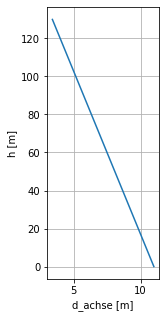

In [5]:
if not querschnitts_dateien_laden:
        querschnitte = []
        qs_werte = []
        qs_labels = []
        höhe = 130
        dicken = [40]#,44]#, 44]#,48,56,64] # key für lagenaufbau dictonaire in holz 
        #knicke = {'gerade':[None,10], '1Knick':[4.5,10], 'Knick mit Übergang':[4.5,8]}
        knicke = {'Gerade':[None, 11]}
        for label, knick in knicke.items():
                for t in dicken:
                        höhen_parameter = {
                                        'nabenhöhe' :höhe,
                                        'd_unten_oben' :[11, 3.4],
                                        'höhe_sektionen' :[12,15], # Range angeben
                                        'd_knick' :knick[0],#None, für keinen Knick -> alle folgenden Parameter sind dann unrelevant
                                        'h_knick_von_oben' :70,
                                        'd_unten_angepasst':knick[1], # damit ein Übergangsknick entseht muss dieser hier kleiner als 'd_unten' sein
                                        'd_knick_übergang':'automatisch',#7.5,# # bei automatisch nimmt es den schon vorhandenen an dieser Stelle
                                        'n_sektionen_übergang':1,
                                        } 

                        lagen_aufbau = holz.lagenaufbauten[t]

                        einheiten_input = {'Kraft':'N', 'Moment':'Nm', 'Festigkeit':'N/mm²', 'Länge':'m'}
                        
                        kreis_ring = KreisRing(cd = 1.1, cp_max=1.8, lagen_aufbau=lagen_aufbau,
                                                holz_parameter = werkstoff_parameter, 
                                                nachweis_parameter = nachweis_parameter,
                                                hoehen_parameter= höhen_parameter, einheiten=einheiten_input,
                                                FE_elements=parameters['n_elements'])

                        kreis_ring.name += ' ' + label + ' t' + str(t)
                        qs_labels.append(kreis_ring.name)
                        qs_values_digits = 2
                        for values in kreis_ring.querschnitts_werte.values():
                                qs_werte.append(np.around(values, qs_values_digits))

                        querschnitte.append(kreis_ring)

        qs_header = pd.MultiIndex.from_product([qs_labels, list(kreis_ring.querschnitts_werte.keys())])

        qs_werte=np.array(qs_werte).transpose()
        qs_df = pd.DataFrame(qs_werte, columns=qs_header)
        holz_df = pd.DataFrame(werkstoff_parameter, index=[0])
        
        # Querschnitts werte werden im Selben Format auch in einem sheet im 'Berechnungs_Ergebnisse' Excel hinzugefügt
        with pd.ExcelWriter(querschnitts_excel, mode= 'w', engine="openpyxl") as writer:# --> mode = 'w', if_sheet_exists='overlay'
                holz_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=0, startcol=0, index=False)
                qs_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=4, startcol=0)
        
        utils.zellen_groeße_formatieren(querschnitts_excel, worksheet= 'QS_Werte', cell_width=15, n_cols=len(holz_df.columns)*2+1)

        print ('\nDie Querschnittswerte über die Höhe sind in', querschnitts_excel, 'geschrieben.')

        kreis_ring.plot_properties_along_height(['d_achse'], h_absolut=True)
        

### Dataframe
- Wird genutzt um die Ergebnisse am Ende einfach in ein Excel zu schreiben
- Der Dataframe muss leer initialisiert werden um verschiedene Level an Headern (Zeilen der Spalten) zu verwenden -> genau diese Namen in den Headern müssen dann benutzt werden um den Dataframe zu füllen
- NOTE muss tatsächlich gar nicht unbedingt initialisiert werden. Die level werden wohl auch richtig hinzugefügt wenn man sie mit dem df.loc ding hinzufügt

In [6]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

from copy import copy

df_results_header_list = [[],[], []] # 1. Liste = 1. Level usw...
kraft_komponenten = ['Fx [kN]', 'Fy [kN]', 'Mz [kNm]','Mx [kNm]']
#df_einwirkung_header_list = [[],[],['Fx [kN]', 'eigengewicht [kN]', 'Fy [kN]', 'F_h,ers,imp [kN]' ,'Mz [kNm]','Mx [kNm]'],['ständig','kurz','egal']]
df_einwirkung_header_list = [[],[],['ständig','kurz','egal'], kraft_komponenten]
df_einwirkung_typ_header_list = [[],[],['Kopflast [kN]', 'windkraft [kN]', 'eigengewicht [kN]', 'F_h,ers,imp [kN]' ],kraft_komponenten]
include_tau = True
include_sigma_M_N = False
include_sgr = True
include_reibung = True

for qs in querschnitte:
    if qs.nabenhöhe not in df_results_header_list[0]:
        df_results_header_list[0].append(qs.nabenhöhe)
        df_einwirkung_header_list[0].append(qs.nabenhöhe)
    if qs.name not in df_results_header_list[1]:
        df_results_header_list[1].append(qs.name)
        df_einwirkung_header_list[1].append(qs.name)

# Berechnungsergebnisse - dritte Ebene:
df_results_header_list[2].append('Höhe [' + qs.einheiten['Länge'] + ']') 
df_results_header_list[2].append('d_achse [' + qs.einheiten['Länge'] + ']') 
#df_results_header_list[2].append('P_erf [MN]') 
df_results_header_list[2].append('P_erf,end [MN]') 

if include_sgr:
    df_results_header_list[2].append('M [MNm]') 
    df_results_header_list[2].append('N [MN]') 
    df_results_header_list[2].append('Q [MN]') 

if include_sigma_M_N:
    df_results_header_list[2].append(GD.GREEK_UNICODE['sigma'] + '_N [' + qs.einheiten['Normalspannung'] + ']') 
    df_results_header_list[2].append(GD.GREEK_UNICODE['sigma'] + '_M [' + qs.einheiten['Normalspannung'] + ']') 
#df_results_header_list[2].append(GD.GREEK_UNICODE['sigma'] + '_zug [' + qs.einheiten['Normalspannung'] + ']') 
df_results_header_list[2].append(GD.GREEK_UNICODE['sigma'] + '_druck [' + qs.einheiten['Normalspannung'] + ']')  
df_results_header_list[2].append('Ausn. druck') 

if include_tau:
    if werkstoff_parameter['Furnierebene']:
        df_results_header_list[2].append(GD.GREEK_UNICODE['tau'] + '_Fe' + ' [' + qs.einheiten['Schubspannung'] + ']') 
        df_results_header_list[2].append(GD.GREEK_UNICODE['tau'] + '_längs' + ' [' + qs.einheiten['Schubspannung'] + ']')
        df_results_header_list[2].append('Ausn. schub Furnier') 
        df_results_header_list[2].append('Ausn. schub längs')  
    else:
        df_results_header_list[2].append(GD.GREEK_UNICODE['tau'] + '_Qy' + ' [' + qs.einheiten['Schubspannung'] + ']') 
        df_results_header_list[2].append(GD.GREEK_UNICODE['tau'] + '_Mx' + ' [' + qs.einheiten['Schubspannung'] + ']') 
        df_results_header_list[2].append(GD.GREEK_UNICODE['tau'] + '_xy' + ' [' + qs.einheiten['Schubspannung'] + ']') 
        df_results_header_list[2].append(GD.GREEK_UNICODE['tau'] + '_tor' + ' [' + qs.einheiten['Schubspannung'] + ']') 
        df_results_header_list[2].append('Ausn. schub brutto') 
        df_results_header_list[2].append('Ausn. schub netto') 
        df_results_header_list[2].append('Ausn. schub torsion') 

if include_reibung:
    df_results_header_list[2].append('nxy_Qy' + ' [' + qs.einheiten['Grundschnittgrößen'] + ']') 
    df_results_header_list[2].append('nxy_Mx' + ' [' + qs.einheiten['Grundschnittgrößen'] + ']') 

    df_results_header_list[2].append('Ausn. reibung') 

# Header in pd Format
df_results_header = pd.MultiIndex.from_product(df_results_header_list, names=['Nabenhöhe', 'Querschnitt', 'Segment'])
df_einwirkungs_header = pd.MultiIndex.from_product(df_einwirkung_header_list, names=['Nabenhöhe', 'Querschnitt', 'Ew. Dauer', 'Komponente', ])
df_einwirkungs_header_typ = pd.MultiIndex.from_product(df_einwirkung_typ_header_list, names=['Nabenhöhe', 'Querschnitt', 'Lasttyp','Komponente', ])
# Dataframes leer 
results_df = pd.DataFrame(columns=df_results_header)
einwirkungs_df = pd.DataFrame(columns=df_einwirkungs_header)
einwirkungs_df_typ = pd.DataFrame(columns=df_einwirkungs_header_typ)#copy(einwirkungs_df)

# Äußere Belastung 


- Windkraft F_w über die Höhe wird nach DIN berechnet (cscd vernachlässigt Bert = 1.01, DIBt 9.3.2: muss im Parkzustand berücksichtigt werden im Analgenbetrieb nicht (Vernachlässigung evtl. nur bei den Ermüdungslastfällen?!)).

$$ F_{w}(z) = c_{s}c_{d} \cdot c_{f} \cdot q_{p}(z) \cdot A_{ref} $$
    
- Angabe eines eigenen cd / cf Werts (drag coefficient bzw. Kraftbeiwert)
- Kopflasten aus IEA37 Min/Max Tabellen
- Schiefstellung 5 mm/m (DIBt Windenergieanlagen Richtlinie 2012 Kapitel 7.4)
- Teilsicherheitsbeiwerte nach IEC 

### Einwirkungsdauer

- Einteilung der Lasten nach dauer 'kurz' und 'ständig' (durch keys in dictonaries)

### Dateinamens Konvention

Die Lasten werden/müssen in einer .npy datei gespeichert werden um vom beam gelesen werden zu können. Für die Dateinamen wird folgende bezeichnugn festgelegt:

- K-IEA@maxFx_ = Kopflasten + Quelle der min max tabelle + angabe aus welcher reihe der min max tabelle 
- W-v17cd1.5_ = Windlast + Basiswindgeschwindigeit + cd Wert
- D-kurz = Dauer der Einwirkung

### TODO
- Knoten Momente berechnen bei der Konvertierung von Linienlast in Punktlasten (Effekt eher klein außer an oberstem und untersten Knoten)
- gamma_q für Windlast ist im IEC gegeben und Lastfall abhängig. Hier 1.35 


Windbelastung aus:
    vb: 17
    terrain: II


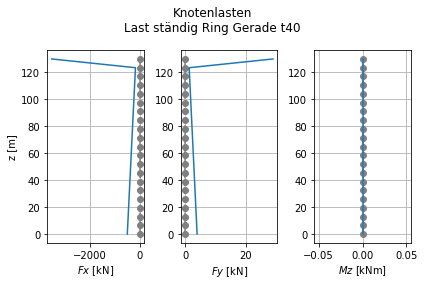

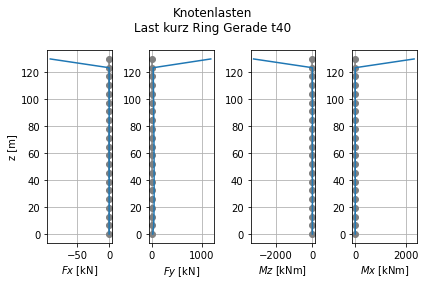

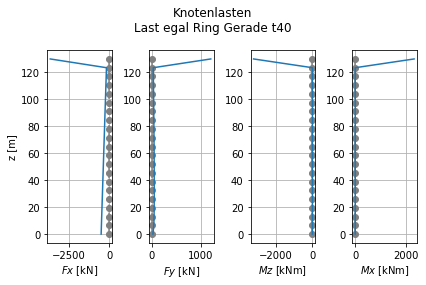

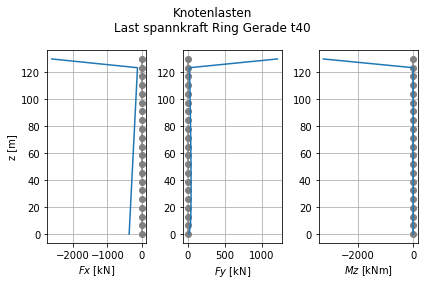

In [7]:
einwirkungsdauer = ['ständig', 'kurz', 'egal','spannkraft']
sicherheitsbeiwerte = {'dlc':1.35, 'wind':1.35, 'g':1.35, 'vorspannung':1.0} # dlc entsprechend der Kopflasten q diesem entsprechend und g TODO ansich komplexer im IEC

kopf_lasten_IEA = {'Fx':1.17E+06,'Fy':4.80E+04, 'Fz':-3.64E+06, 'Mx':6.81E+06, 'My':3.24E+06, 'Mz':2.31E+06}# NOTE Mx = Mxy #Masse charakt. 2.62E+06
kopf_masse = - parameters['nacelle_mass'] * GD.GRAVITY * sicherheitsbeiwerte['g'] # -2628197
# Design lasten schon 
kopf_lasten_beam = utils.convert_coordinate_system_and_consider_einwirkungsdauer(kopf_lasten_IEA, n_nodes, sicherheitsbeiwerte['g'], kopf_masse = kopf_masse) 

import inputs.DIN_Windlasten as wind_DIN

basis_windgeschwindigkeit = 17
terrain_kategorie = 'II'
einwirkungs_parameter = {'vb':basis_windgeschwindigkeit,'Terrain Kategorie':terrain_kategorie, 'Kopflast':'@max Fx', 'DLC':'1.3_seed2_9ms'}
einwirkungs_parameter.update(sicherheitsbeiwerte)
einwirkungs_parameter_df = pd.DataFrame(einwirkungs_parameter, index=[0])

grund_parameter = {'Querschnitt': [q.name for q in querschnitte],
                    't [m]': [q.wand_stärke for q in querschnitte],
                    'Nabenhöhe [m]': [q.nabenhöhe for q in querschnitte],
                    'cd': [q.cd for q in querschnitte],
                    'Volumen [m³]':[round(sum(q.V),2) for q in querschnitte]
}
grund_parameter_df = pd.DataFrame(grund_parameter)

print ('Windbelastung aus:')
print ('    vb:', basis_windgeschwindigkeit)
print ('    terrain:', terrain_kategorie)
#wind_DIN.plot_DIN_all(basis_windgeschwindigkeit, categories=[terrain_kategorie])

wind_kraft_z = {}
lasten_files, lasten_dicts_dauer, lasten_dicts_typ = {}, {}, {}
for qs in querschnitte:
    # Infromationen vom QS Objekt holen
    QS_label = qs.name

    lasten_dict_base = {'Fx':np.zeros(n_nodes), 'Fy':np.zeros(n_nodes), 'Mz':np.zeros(n_nodes)}
    # Koordinaten definiton abweichend + gleichzeitig einteilung der Lasten in Einwirkungsdauer

    # Ergebniss Daten vorbereiten -> leer initialisieren nur wenn noch nicht leer 
    if QS_label not in lasten_files:
        lasten_files[QS_label] = {}
        lasten_dicts_dauer[QS_label], lasten_dicts_typ[QS_label] = {}, {}

    if qs.nabenhöhe not in lasten_files[QS_label]:
        lasten_files[QS_label][qs.nabenhöhe] = {}
        lasten_dicts_dauer[QS_label][qs.nabenhöhe], lasten_dicts_typ[QS_label][qs.nabenhöhe] = {}, {}

    # Lastberechnung für den spezifischen QS
    v_z, Iv_z, qp_z, z = wind_DIN.DIN_potenz_profil(basis_windgeschwindigkeit, terrain_kategorie, qs.nabenhöhe)
   
    wind_kraft_z, z_coords = wind_DIN.wind_kraft(vb=basis_windgeschwindigkeit, category=terrain_kategorie, height=qs.x_fe, cd = qs.cd, Aref=qs.d_achse_FE) # ergibt N/m
    knoten_wind_kraft_z = utils.linien_last_to_knoten_last(wind_kraft_z, qs.x_fe, gamma_q = sicherheitsbeiwerte['wind']) # NOTE gamma_q nach IEC DLC 1.3
    #ebenen_wind_kraft_z = utils.linien_last_to_knoten_last(wind_kraft_z, qs.section_absolute_heights, gamma_q = sicherheitsbeiwerte['wind']) # NOTE gamma_q nach IEC 
    
    #postprocess.plot_along_height(knoten_wind_kraft_z, z_coords, label='wind_kraft [N]')

    gewichtskraft_FE_design = {k: sicherheitsbeiwerte['g']*v for k,v in qs.gewichtskraft_FE.items()} # im QS ist die charakteristische gespeichert

    #_____Lasten sortiert nach Typ der Last
    lasten_dicts_typ[QS_label][qs.nabenhöhe]['kopflast'] = kopf_lasten_beam['egal']
    lasten_dicts_typ[QS_label][qs.nabenhöhe]['windkraft'] = knoten_wind_kraft_z
    lasten_dicts_typ[QS_label][qs.nabenhöhe]['eigengewicht'] = gewichtskraft_FE_design
    F_h_imp_ers = utils.horizontale_ersatzlast([gewichtskraft_FE_design, kopf_lasten_beam['egal']], theta_x = parameters['imperfektion'])
    lasten_dicts_typ[QS_label][qs.nabenhöhe]['F_h,ers,imp'] = F_h_imp_ers

    # _____nach Einwirkungsdauer
    lasten_dicts_dauer[QS_label][qs.nabenhöhe]['egal']  = utils.update_lasten_dict(lasten_dict_base, [knoten_wind_kraft_z, F_h_imp_ers, gewichtskraft_FE_design, kopf_lasten_beam['egal']]) 
    lasten_dicts_dauer[QS_label][qs.nabenhöhe]['kurz'] = utils.update_lasten_dict(lasten_dict_base, [knoten_wind_kraft_z, kopf_lasten_beam['kurz']])
    lasten_dicts_dauer[QS_label][qs.nabenhöhe]['ständig']  = utils.update_lasten_dict(lasten_dict_base, [gewichtskraft_FE_design, F_h_imp_ers, kopf_lasten_beam['ständig']])
    # das ist der Lastfall für die Spannkraftberechnung und nicht wirklich eine Last
    lasten_dicts_dauer[QS_label][qs.nabenhöhe]['spannkraft']  = utils.update_lasten_dict(lasten_dict_base, [knoten_wind_kraft_z, qs.gewichtskraft_FE, F_h_imp_ers, kopf_lasten_beam['spannkraft']])
   
    # ____________ LASTEN DATEI GENERIEREN - nur nach dauer sortiert da dies relevant für ausnutzung ist ___________________________
    for dauer in einwirkungsdauer:
        filename = 'K-IEA@maxFx_' + 'W-v' +str(basis_windgeschwindigkeit) + 'cd' + str(qs.cd) + '_D-' + dauer
        lasten_files[QS_label][qs.nabenhöhe][dauer] = utils.generate_lasten_file(n_nodes, lasten_dicts_dauer[QS_label][qs.nabenhöhe][dauer], file_base_name=filename)
    
    # Händische Torsion dazu 
    lasten_dicts_dauer[QS_label][qs.nabenhöhe]['egal']['Mx']  = np.append(np.zeros(parameters['n_elements']), kopf_lasten_IEA['Mz'])
    lasten_dicts_dauer[QS_label][qs.nabenhöhe]['kurz']['Mx']  = np.append(np.zeros(parameters['n_elements']), kopf_lasten_IEA['Mz'])
    lasten_dicts_typ[QS_label][qs.nabenhöhe]['kopflast']['Mx'] = np.append(np.zeros(parameters['n_elements']), kopf_lasten_IEA['Mz'])

    for dauer in einwirkungsdauer:
        if dauer == 'spannkraft':
            continue
        for komponente in lasten_dicts_dauer[QS_label][qs.nabenhöhe][dauer]:
            if komponente in ['Mz','Mx']:
                einheiten = ['Nm','kNm']
            else:
                einheiten = ['N','kN']
            
            einwirkungs_df.loc[:,(qs.nabenhöhe, QS_label, dauer, komponente + ' [' + einheiten[1] + ']')] =\
                np.around(lasten_dicts_dauer[QS_label][qs.nabenhöhe][dauer][komponente] * utils.unit_conversion(einheiten[0],einheiten[1]),2)

    for typ in lasten_dicts_typ[QS_label][qs.nabenhöhe]:
        filename = 'K-IEA@maxFx_' + 'W-v' +str(basis_windgeschwindigkeit) + 'cd' + str(qs.cd) + '_D-' + typ
        lasten_files[QS_label][qs.nabenhöhe][typ] = utils.generate_lasten_file(n_nodes, lasten_dicts_typ[QS_label][qs.nabenhöhe][typ], file_base_name=filename)
        for komponente in lasten_dicts_typ[QS_label][qs.nabenhöhe][typ]:
            if komponente in ['Mz','Mx']:
                einheiten = ['Nm','kNm']
            else:
                einheiten = ['N','kN']

            einwirkungs_df_typ.loc[:,(qs.nabenhöhe, QS_label, typ, komponente + ' [' + einheiten[1] + ']')] =\
                np.around(lasten_dicts_typ[QS_label][qs.nabenhöhe][typ][komponente] * utils.unit_conversion(einheiten[0],einheiten[1]),2)

    if qs.nabenhöhe == 30:
        postprocess.plot_dict_subplots(lasten_dicts_typ[QS_label][qs.nabenhöhe]['windkraft'], qs.x_fe, title='Windkraft ' + QS_label, unit='kN')
        postprocess.plot_dict_subplots(lasten_dicts_dauer[QS_label][qs.nabenhöhe]['egal'], qs.x_fe, title='Windkraft + Kopflasten gesamt ' + QS_label, unit = 'kN')

    plot_nach_dauer = True
    if plot_nach_dauer:
        for dauer in einwirkungsdauer:
            postprocess.plot_dict_subplots(lasten_dicts_dauer[QS_label][qs.nabenhöhe][dauer], qs.x_fe, title='Last ' + dauer +' ' + QS_label, unit = 'kN')





# Schnittgrößen

- Balkenmodell initiieren (für jeden Querschnitt)
- Statisch Berechnung -> Schnittgrößen entlang der Höhe
- Berechnung für die vom Querschnitt abhängigen Lasten
- Unterscheidung der Einwirkungsdauer 
- Eigengewicht des Turms mit einbeziehen -> 'ständig'
- Horizontale ersatzlast infolge Schiefstellung (ungünstig zur wirkenden Horizontalkraft addieren) -> 'ständig'
- Vergleich: Moment am Fuß IEA @ max Fx: 128 MNm

### TODO
- Teilsicherheitsbeiwert Eigengewicht komplexer -> Kapitel 7.6.2.2 Tabelle 3 IEC 61400
- bis dahin gamma_g = 1.35

N_nodes 10
Ring Gerade t40 130 m
     Gesamt Volumen des Querschnitts [m³]: 1046.83
     Gesamt Gewichtskraft Turm am Fuß [MN]: -4.72
     Frequenzen [Hz]: [0.328, 2.142, 6.106]


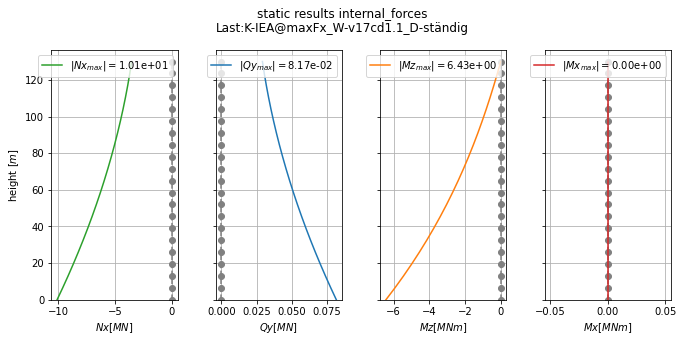

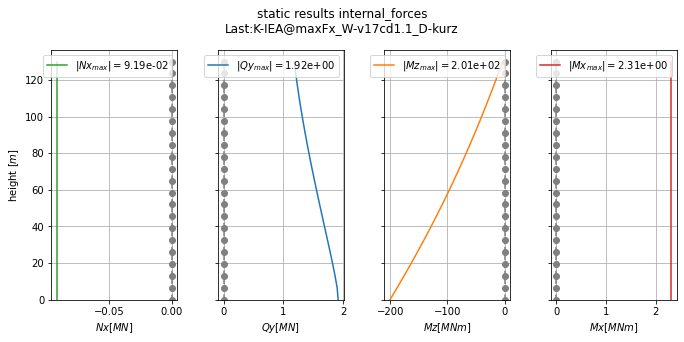

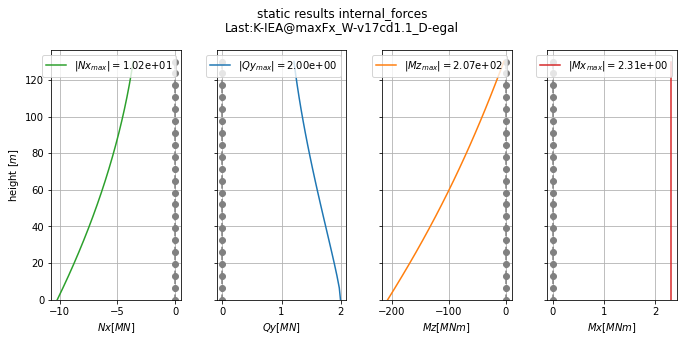

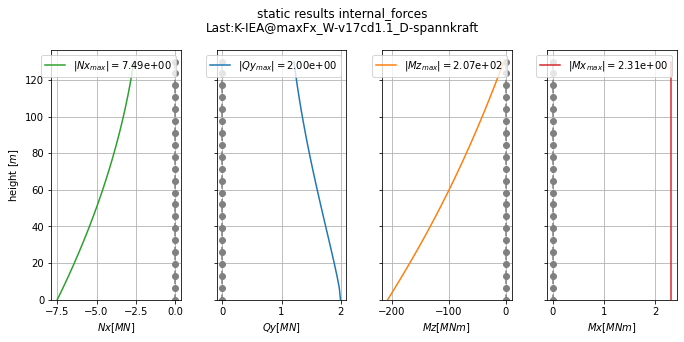

     Maximales Moment [MNm]: 206.94
     Maximales Moment ohne Kopflast [MNm] ~= 54.84


In [8]:
schnittgrößen_design = {}

for querschnitt in querschnitte:
    QS_label = querschnitt.name
    nabenhöhe = querschnitt.nabenhöhe

    if QS_label not in schnittgrößen_design:
        schnittgrößen_design[QS_label] = {}
    if nabenhöhe not in schnittgrößen_design[QS_label]:
        schnittgrößen_design[QS_label][nabenhöhe] = {}

    section_properties = querschnitt.section_parameters 

    parameters = utils.add_model_data_from_dict(section_properties, parameters)

    beam = BeamModel(parameters, adjust_mass_density_for_total = False, optimize_frequencies_init=False , apply_k_geo=False)
    
    print ('N_nodes', querschnitt.n_ebenen)
    print (QS_label, nabenhöhe, 'm')
    print ('     Gesamt Volumen des Querschnitts [m³]:', round(beam.volume,2))
    print ('     Gesamt Gewichtskraft Turm am Fuß [MN]:',round(sum(beam.eigengewicht * GD.UNIT_SCALE['MN']),2))
    print ('     Frequenzen [Hz]:', [round(beam.eigenfrequencies[i],3) for i in range(3)])

    lasten_nach_dauer = {'ständig':{'torsion':False},
                         'egal':{'torsion':kopf_lasten_IEA['Mz']},
                         'kurz':{'torsion':kopf_lasten_IEA['Mz']},
                         'spannkraft':{'torsion':kopf_lasten_IEA['Mz']}}

    for dauer in einwirkungsdauer:
        # NOTE Torsion ist nicht in der Steifigkeitsmatrix, deswegen kann diese brechnung nur händisch ergänzt werden
        lasten_file = lasten_files[QS_label][nabenhöhe][dauer]
        schnittgrößen_design[QS_label][nabenhöhe][dauer] = {}

        # TODO für Spannkraft berechnung bracuht man alle SGR ohne sicherheiten der eigengewichte bzw. mit 1.0 da günstig 
        schnittgrößen_design_fe = beam.static_analysis_solve(load_vector_file=lasten_file, 
                                                             constant_torsion = lasten_nach_dauer[dauer]['torsion'])
        for key in schnittgrößen_design_fe:
            schnittgrößen_design[QS_label][nabenhöhe][dauer][key] = utils.interpolate(z_soll = querschnitt.section_absolute_heights, 
                                                                                        z_ist=beam.nodal_coordinates['x0'], 
                                                                                        werte = schnittgrößen_design_fe[key])

        lasten_label = os.path.splitext(os.path.basename(lasten_files[QS_label][nabenhöhe][dauer]))[0]
        postprocess.plot_static_result_forces(beam, 'internal_forces', ['x','y','g','a'], unit='MN', title_suffix='Last:' + lasten_label, figsize_scale = 1.5)
                                                                                        
                
    print ('     Maximales Moment [MNm]:', round(max(abs(schnittgrößen_design[QS_label][nabenhöhe]['egal']['g'])) * utils.unit_conversion('Nm', 'MNm'),2))   
    print ('     Maximales Moment ohne Kopflast [MNm] ~=', round((max(abs(schnittgrößen_design[QS_label][nabenhöhe]['egal']['g'])) - kopf_lasten_IEA['Fx']*nabenhöhe) * utils.unit_conversion('Nm', 'MNm'),2))   

    # Wenn was geplotet werden soll hier mit if angeben für welchen querschnitt aus der liste oder einfach ohne if dann für alle  
    plot_sgr = False                                                            
    if plot_sgr:
        lasten_label = os.path.splitext(os.path.basename(lasten_files[QS_label][nabenhöhe]['egal']))[0]
        postprocess.plot_static_result_forces(beam, 'internal_forces', ['x','y','g','a'], unit='MN', title_suffix='Last:' + lasten_label, figsize_scale = 1.1)
        #postprocess.plot_static_result(beam, 'deformation', ['y'], unit='cm',title_suffix='Last:' + lasten_label,)
        #postprocess.plot_static_result(beam, 'deformation', ['g'], unit='cm',title_suffix='Last:' + lasten_label,)


# Berechnung der Spannungen

- Für die Liste an Querschnitten werden mit den Entsprechenden Schnittgrößen die Spannungen berechnet
- Bisher nur Normalspannugen infolge Biegung und Normalkraft
- Ausnutzung aufgrund der Druckspannungen aus Moment, Imperfektion und Normalkraft 
- Druckspannung infolge Vorspannkraft wird in einer ersten Annährung durch die Zugspannung abgedeckt
- der Dataframe wird gefüllt und in eine Excel geschrieben
- WICHTIG: der pd.ExcelWriter unterscheided zwischen mode 'w' = 'write' und 'a' = 'append'. Für 'w' wird alles neu geschrieben also der Inhalt der Datei quasi erst gelöscht und dann gefüllt. Mit 'a' kann eine Vorhandene Datei erweitert werden -> mit if_sheet_exists = 'overlay' werden auch die einzelnen Arbeitsblätter nicht gelöscht bevor sie geschrieben werden

### TODO
- Vorspannkratverluste (iterativ) bestimmen und erforderliche Anzahl an Spanngleidern mit betimmter Anzahl an Drähten ausgeben -> Angefangen hier: Querschnitt.spannkraft_berechnen()
- Staffelung der Vorspannung

In [9]:
max_ausnutzung = {}
for querschnitt in querschnitte:
  QS_label = querschnitt.name
  nabenhöhe = querschnitt.nabenhöhe
  t = round(querschnitt.wand_stärke * 100) # cm
  tX = querschnitt.t_laengslagen * 100
  tY = querschnitt.t_querlagen * 100
  if QS_label not in max_ausnutzung:
    max_ausnutzung[QS_label] = {}
    
  last = utils.parse_schnittgrößen_labels(schnittgrößen_design[QS_label][nabenhöhe])

  querschnitt.spannkraft_berechnung(last, spannglied_parameter, verluste_pauschal = spannkraft_verlust_pauschal,  unit = 'MN') # NOTE muss bisher vor ausnutzung bestimmt werden 
  querschnitt.calculate_ausnutzung_normalspannung(last, add_vorspannkraft_grob = True, plot_spannungsverlauf=False)
  #TODO das ist nicht gut hier da scheibenschub berechnung zwingend nach allen anderen gemacht werden muss da die Querschnittswerte verändert werden
  querschnitt.calculate_ausnutzung_scheibenschub(last, lamellenbreite=0.13)
  querschnitt.compute_effektive_festigkeiten_design('kurz')

  # einwirkungs_df_typ.loc[:,(nabenhöhe, QS_label, typ, 'Fx [' + einheiten[1] + ']')] =\
  #               np.around(lasten_dicts_typ[QS_label][nabenhöhe][typ][komponente] * utils.unit_conversion(einheiten[0],einheiten[1]),2)
 #Nebentragrichtung ny
 # querschnitt.nachweis_normalspannung_y(lasten_dicts_lokaleflaeche['kurz'])
 # querschnitt.ausnutzung_Plattenbeanspruchung_Nebentragrichtung(lasten_dicts_lokaleflaeche['kurz'], 3.5)

  # NOTE Syntax: results_df.loc[:, (Level1, Level2, Level3)] = daten
  results_df.loc[:,(nabenhöhe, QS_label, 'Höhe [' + querschnitt.einheiten['Länge'] + ']')] = np.around(querschnitt.section_absolute_heights,2)
  results_df.loc[:,(nabenhöhe, QS_label, 'd_achse [' + querschnitt.einheiten['Länge'] + ']')] = np.around(querschnitt.d_achse,2)
  if include_sgr:
    results_df.loc[:,(nabenhöhe, QS_label, 'M [MNm]')] = np.around(schnittgrößen_design[QS_label][nabenhöhe]['egal']['g']* utils.unit_conversion('Nm', 'MNm') ,2)
    results_df.loc[:,(nabenhöhe, QS_label, 'N [MN]')] = np.around(schnittgrößen_design[QS_label][nabenhöhe]['egal']['x']* utils.unit_conversion('N', 'MN') ,2)
    results_df.loc[:,(nabenhöhe, QS_label, 'Q [MN]')] = np.around(schnittgrößen_design[QS_label][nabenhöhe]['egal']['y']* utils.unit_conversion('N', 'MN') ,2)

  #results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_zug [' + querschnitt.einheiten['Normalspannung'] + ']')] = np.around(querschnitt.sigma_zug_design,2)
  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_druck [' + querschnitt.einheiten['Normalspannung'] + ']')] = np.around(querschnitt.sigma_druck_design,2)
  results_df.loc[:,(nabenhöhe, QS_label, 'Ausn. druck')] = np.around(querschnitt.ausnutzung_druck,3)
  max_ausnutzung[QS_label][str(nabenhöhe) + ' m'] = max(querschnitt.ausnutzung_druck)

  #results_df.loc[:,(nabenhöhe, QS_label, 'P_erf [MN]')] = np.around(querschnitt.P_erf * utils.unit_conversion('N', 'MN') ,2)
  results_df.loc[:,(nabenhöhe, QS_label, 'P_erf,end [MN]')] = np.around(querschnitt.P_m0 * utils.unit_conversion('N', 'MN') ,2)

  if include_tau:
    if werkstoff_parameter['Furnierebene']:
      results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['tau'] + '_Fe' + ' [' + qs.einheiten['Schubspannung'] + ']')] = np.around(querschnitt.tau_Fe_design,2)    
      results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['tau'] + '_längs' + ' [' + qs.einheiten['Schubspannung'] + ']')] = np.around(querschnitt.tau_längs_design,2)
         
      results_df.loc[:,(nabenhöhe, QS_label, 'Ausn. schub Furnier')] = np.around(querschnitt.ausnutzung_schub_Fe,3)
      results_df.loc[:,(nabenhöhe, QS_label, 'Ausn. schub längs')] = np.around(querschnitt.ausnutzung_schub_längs,3)

      results_df.loc[:,(nabenhöhe, QS_label, 'fvd_Fe')] = np.around(querschnitt.fvFed,3)
      results_df.loc[:,(nabenhöhe, QS_label, 'fvd_längs')] = np.around(querschnitt.fvd_brutto,3)
    else:
      results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['tau'] + '_Qy' + ' [' + qs.einheiten['Schubspannung'] + ']')] = np.around(querschnitt.tau_Qy_design,2)
      results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['tau'] + '_Mx' + ' [' + qs.einheiten['Schubspannung'] + ']')] = np.around(querschnitt.tau_Mx_design,2)
      results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['tau'] + '_xy' + ' [' + qs.einheiten['Schubspannung'] + ']')] = np.around(querschnitt.tau_xy_design,2)    
      results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['tau'] + '_tor' + ' [' + qs.einheiten['Schubspannung'] + ']')] = np.around(querschnitt.tau_vtor_design,2)
         
      results_df.loc[:,(nabenhöhe, QS_label, 'Ausn. schub brutto')] = np.around(querschnitt.ausnutzung_schub_brutto,3)
      results_df.loc[:,(nabenhöhe, QS_label, 'Ausn. schub netto')] = np.around(querschnitt.ausnutzung_schub_netto,3)
      results_df.loc[:,(nabenhöhe, QS_label, 'Ausn. schub torsion')] = np.around(querschnitt.ausnutzung_schub_torsion,3)

      results_df.loc[:,(nabenhöhe, QS_label, 'fvd_brutto')] = np.around(querschnitt.fvd_brutto,3)
      results_df.loc[:,(nabenhöhe, QS_label, 'fvd_netto')] = np.around(querschnitt.fvxyd_netto,3)
      results_df.loc[:,(nabenhöhe, QS_label, 'fvd_tor')] = np.around(querschnitt.fvtord,3)
  
  if include_sigma_M_N:
    results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_N [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_N_design
    results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_M [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_M_design
  

max_results_df = pd.DataFrame(max_ausnutzung)
print ('Maximale Ausnutzungen')
print (max_results_df)

#______________________ ALLES IN EXCEL SPEICHERN _________________________________________________________________________________________
d_rows = grund_parameter_df.shape[0] + 7 + results_df.shape[0]
# TODO bisschen arg händisch bisher -> um Ergebnisse verschiedener QS Wandstärken in einer Datei untereinander zu schreiben
start_row_ti = {36:0, 40:0, 44:0, 48:0, 56:0, 64:0}#d_rows 2*d_rows
start_row_max_ti = {36:1, 40:1, 44:1, 48:1, 56:1, 64:1}#+8+16

with pd.ExcelWriter(results_excel, mode= 'w', engine="openpyxl") as writer:# --> mode = 'a', if_sheet_exists='overlay'
  nrows = start_row_ti[int(t)] + grund_parameter_df.shape[0]
  ausnutzungs_cols = utils.get_spalten_ausnutzung(results_df, df_results_header_list, start_row = nrows+2, start_col = 0)

  holz_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=0, startcol=0, index=False)#
  qs_df.to_excel(writer, sheet_name= 'QS_Werte', startrow=4, startcol=0)

  einwirkungs_parameter_df.to_excel(writer, sheet_name= 'Einwirkung_design', startrow=0, startcol=0, index=False)
  einwirkungs_df.to_excel(writer, sheet_name= 'Einwirkung_design', startrow=4, startcol=0)
  einwirkungs_df_typ.to_excel(writer, sheet_name= 'Einwirkung_design', startrow=einwirkungs_df.shape[0]+12, startcol=0)

  results_df.to_excel(writer, sheet_name= 'Berechnungs_Ergebnisse', startrow=nrows+2, startcol=0, index=True)#, float_format='%.4f')
  grund_parameter_df.to_excel(writer, sheet_name= 'Berechnungs_Ergebnisse', startrow=start_row_ti[int(t)], startcol=0, index=False)
  max_results_df.to_excel(writer, sheet_name= 'Ausnutzungen_max', startrow=start_row_max_ti[t], index=True)

utils.zellen_groeße_formatieren(results_excel, worksheet= 'Einwirkung_design', cell_width=15, n_cols=len(einwirkungs_df.columns)+1)
utils.zellen_groeße_formatieren(results_excel, worksheet= 'QS_Werte', cell_width=15, n_cols=len(qs_df.columns)+1)
utils.zellen_groeße_formatieren(results_excel, worksheet= 'Berechnungs_Ergebnisse', cell_width=15, n_cols=len(results_df.columns)+1)
utils.zellen_groeße_formatieren(results_excel, worksheet= 'Ausnutzungen_max', cell_width=20, n_cols=len(max_results_df.columns)+1)

utils.add_databar_color(results_excel, worksheet = 'Berechnungs_Ergebnisse', columns = ausnutzungs_cols)

utils.zelle_beschriften(results_excel, 'Ausnutzungen_max', 'B' + str(start_row_max_ti[t]), 
                       't, tX, tY [cm] ' + ', '.join([str(int(t)), str(round(tX,1)), str(round(tY,1))]) ,'B' + str(start_row_max_ti[t])+ ':E'+ str(start_row_max_ti[t]))

              
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M")
print ('Ergebnisse in ', results_excel, 'geschrieben -', dt_string)


Verwende Furnierebenen Ansatz für die Schubspannungsberechnung

Schub Brutto Nachweis nur mit Schmalseitenverklebten Aufbauten (laut VO7)!
Maximale Ausnutzungen
       Ring Gerade t40
130 m         1.006327
Ergebnisse in  output\Berechnungs_Ergebnisse.xlsx geschrieben - 27/10/2022 14:41
